## Setup

In [1]:
import sys
sys.path.insert(0, '/home/ravi/Desktop/eelfff')

In [2]:
import copy
from datetime import datetime
from FireSimulator import *
from FireSimulatorUtilities import *
import glob
import itertools
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## Greedy method

In [10]:
fire_neigh = [(-1,0),(1,0),(0,-1),(0,1)]

In [11]:
def heuristic(sim, size_control):
    action = []
    grid_size = sim.grid_size
    center = (grid_size+1)//2
    cc = x_to_col(center)
    center_idx = np.asscalar(np.ravel_multi_index(np.array([[cc],[cc]]),(grid_size,grid_size),order='F'))
    fires = sim.fires
    scores = {}
    for s in range(5):
        scores[s] = []
        
    for (x,y) in fires:
        rf = y_to_row(grid_size,y)
        cf = x_to_col(x)
        
        counter = 0
        for (dr,dc) in fire_neigh:
            rn = rf + dr
            cn = cf + dc
            if rn>=0 and rn<grid_size and cn>=0 and cn<grid_size and sim.state[rn,cn] in [0]:
                counter += 1
                
        #e = np.ravel_multi_index(np.array([[rf],[cf]]),(grid_size,grid_size),order='F')
        #scores[counter].append(np.asscalar(e))
        scores[counter].append((x,y))
        
    using_set = 4
    while(len(action) < size_control):
        if using_set >= 0:
            if not scores[using_set]:
                using_set += -1
                continue

            for e in scores[using_set]:
                action.append(e)

                if len(action) >= size_control:
                    break
                    
            using_set += -1
    
        else:
            action.append(center_idx)
            
    return action

## Benchmark greedy solution

In [79]:
results = []

In [80]:
grid_size = 50
num_control = 100
seeds = range(1000)

dp = 0.15/0.2763

x = math.ceil(grid_size / 2)
deltas = [q for q in range(-5,5,1)]
neighbors = itertools.product(deltas,deltas)
fire_init = []
for (dx,dy) in neighbors:
    xn = x + dx
    yn = x + dy
    fire_init.append((xn,yn))

In [81]:
tic = time.clock()
# run simulator many times
for i,s in enumerate(seeds):
    np.random.seed(1000+s)
    
    # initialize simulator
    sim = FireSimulator(grid_size, rng=s, fire_init=fire_init)
    
    #sim = FireSimulator(grid_size, rng=s)
    #sim.step([]) # start fire in domain
    
    num_init_fires = len(sim.fires)
    
    seed_rew = 0
    control = []
    
    while not sim.end:
        # generate state
        state = sim.state.reshape((grid_size**2, ))
        
        # get action and reward
        control = heuristic(sim, num_control)
        
        # apply action and update simulator
        sim.step(control, dbeta=dp)
        control = []
        
        if sim.end:
            continue
                            
    if (i+1) % 100 == 0:
        print("finished %d simulations" % (i+1))
    
    # store simulation result
    results.append(sim.stats[2]/np.sum(sim.stats)) # fraction of burned trees
    
toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

finished 100 simulations
finished 200 simulations
finished 300 simulations
finished 400 simulations
finished 500 simulations
finished 600 simulations
finished 700 simulations
finished 800 simulations
finished 900 simulations
finished 1000 simulations
7.58s = 0.13m elapsed


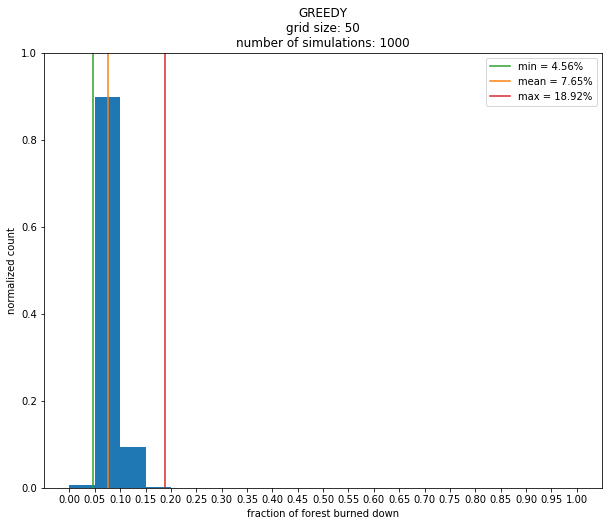

In [82]:
plt.figure()
weights = np.ones_like(results)/float(len(results))
splits, _, _ = plt.hist(results, bins=np.arange(0,1+0.05,0.05), normed=False, weights=weights)
plt.axvline(np.amin(results),color="C2",label="min = %0.2f%%" % (np.amin(results)*100))
plt.axvline(np.mean(results),color="C1",label="mean = %0.2f%%" %(np.mean(results)*100))
plt.axvline(np.amax(results),color="C3",label="max = %0.2f%%" %(np.amax(results)*100))

plt.ylim([0,1])
plt.xticks(np.arange(0,1+0.05,0.05))
plt.xlabel('fraction of forest burned down')
plt.ylabel('normalized count')
plt.title('GREEDY\ngrid size: %d\nnumber of simulations: %d' %(grid_size,len(results)))
plt.legend(loc=1)

# plt.savefig('greedy.png', bbox_inches='tight')

In [83]:
splits

array([ 0.006,  0.899,  0.093,  0.002,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ])

In [84]:
np.mean(results)

0.076543200000000006

In [85]:
with open('greedy_%d+%d+%d+%d.pkl' %(grid_size,num_control,num_init_fires,len(seeds)), 'wb') as fp:
    pickle.dump(results, fp)

In [86]:
if np.amax(results)<=0.90:
    print('fraction of wins: 1.00')
    print('win mean: %0.2f' %(np.mean(results)*100))
else:
    win_results = [x for x in results if x <= np.mean(results)]
    print('fraction of wins: %0.2f' % (100.0*len(win_results)/len(results)))
    print('win mean: %0.2f' %(np.mean(win_results)*100))

fraction of wins: 1.00
win mean: 7.65
